# Sistema de Recomendação de Profissões do Futuro

## FIAP Global Solution - Front End & Mobile Development

**Integrantes:**
- PAULO CARVALHO RUIZ BORBA	                RM554562
- LORENA BAUER NOGUEIRA		                RM555272
- HERBERT DI FRANCO MARQUES	                RM556640

---

Este notebook implementa um sistema de recomendação que auxilia usuários a identificarem profissões do futuro compatíveis com suas habilidades atuais, utilizando Machine Learning e dados do O*NET e Bureau of Labor Statistics.

##Importação de Bibliotecas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

# Utilidades
import joblib
import requests
import json
import warnings
from pathlib import Path

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuração de exibição do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print(" Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


---
# SEÇÃO 1: Carregamento e Limpeza dos Dados

Nesta seção, iremos:
- Carregar dados do O*NET (ocupações, habilidades)
- Simular dados de projeções de crescimento
- Limpar e normalizar os dados
- Realizar feature engineering
- Exportar dados processados

## 1.1 Download e Carregamento de Dados

In [2]:
# Criar diretório de dados se não existir
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

print("Diretório de dados criado/verificado.")

Diretório de dados criado/verificado.


### Dados de Ocupações (O*NET Simplificado)

Para este projeto, vamos criar um dataset sintético baseado em categorias reais do O*NET com profissões relevantes para o futuro do trabalho.

In [3]:
# Dataset de ocupações (baseado em tendências reais do mercado)
occupations_data = {
    'occupation_code': [
        '15-1252.00', '15-1299.08', '15-1256.00', '15-1244.00', '15-1299.09',
        '11-3021.00', '13-1161.01', '19-3033.00', '29-1141.03', '29-1299.01',
        '27-3042.00', '41-3099.01', '11-3121.00', '13-1199.05', '15-1299.07',
        '17-2199.10', '19-4061.00', '25-1194.00', '27-1014.00', '43-9199.01'
    ],
    'occupation_title': [
        'Software Developers', 'Data Scientists', 'Software Quality Assurance Analysts',
        'Network and Computer Systems Administrators', 'Cybersecurity Analysts',
        'Computer and Information Systems Managers', 'Market Research Analysts',
        'Clinical Data Managers', 'Physician Assistants', 'Telemedicine Physicians',
        'Technical Writers', 'Sales Representatives (Renewable Energy)',
        'Human Resources Managers', 'Sustainability Specialists',
        'Machine Learning Engineers', 'Robotics Engineers', 'Social Science Research Assistants',
        'Career and Technical Education Teachers', 'Multimedia Artists and Animators',
        'Customer Service Representatives (Remote)'
    ],
    'description': [
        'Develop and maintain software applications and systems',
        'Analyze complex data to help organizations make better decisions',
        'Test software for quality and performance',
        'Manage and maintain computer networks and systems',
        'Protect computer systems from cyber threats',
        'Plan and direct IT-related activities',
        'Research market conditions and consumer preferences',
        'Manage and analyze clinical trial data',
        'Practice medicine under physician supervision',
        'Provide medical care through telemedicine platforms',
        'Create technical documentation and manuals',
        'Sell renewable energy products and services',
        'Plan and coordinate human resource activities',
        'Develop and implement sustainability strategies',
        'Design and build machine learning systems',
        'Design and develop robotic systems',
        'Assist in social science research projects',
        'Teach vocational and technical subjects',
        'Create visual effects and animations',
        'Provide remote customer support and service'
    ],
    'median_salary': [
        110140, 103500, 99620, 88400, 112000,
        159010, 68230, 89830, 121530, 135000,
        78060, 79990, 126230, 81410, 120000,
        105000, 51500, 62000, 78790, 38080
    ]
}

df_occupations = pd.DataFrame(occupations_data)
print(f" Dataset de ocupações criado: {len(df_occupations)} profissões")
df_occupations.head()

✅ Dataset de ocupações criado: 20 profissões


,occupation_code,occupation_title,description,median_salary
0,15-1252.00,Software Developers,Develop and maintain software applications and...,110140
1,15-1299.08,Data Scientists,Analyze complex data to help organizations mak...,103500
2,15-1256.00,Software Quality Assurance Analysts,Test software for quality and performance,99620
3,15-1244.00,Network and Computer Systems Administrators,Manage and maintain computer networks and systems,88400
4,15-1299.09,Cybersecurity Analysts,Protect computer systems from cyber threats,112000


### Dados de Projeções de Crescimento

In [4]:
# Projeções de crescimento (2024-2034) - baseado em tendências do BLS
growth_data = {
    'occupation_code': df_occupations['occupation_code'].tolist(),
    'projected_growth': [
        25.7, 35.8, 22.4, 4.7, 32.4,
        15.4, 18.6, 7.3, 27.6, 28.3,
        11.9, 24.2, 8.6, 19.7, 40.1,
        9.7, 6.8, 5.4, 16.2, 4.1
    ],
    'num_jobs_2024': [
        1847900, 168200, 203900, 350300, 163000,
        482600, 792500, 12500, 148100, 8900,
        56900, 45200, 165200, 15700, 42300,
        18700, 45800, 232500, 76900, 3008900
    ]
}

df_growth = pd.DataFrame(growth_data)
df_growth['num_jobs_2034'] = (df_growth['num_jobs_2024'] * 
                               (1 + df_growth['projected_growth'] / 100)).astype(int)

print(f" Dataset de projeções criado")
df_growth.head()

✅ Dataset de projeções criado


,occupation_code,projected_growth,num_jobs_2024,num_jobs_2034
0,15-1252.00,25.7,1847900,2322810
1,15-1299.08,35.8,168200,228415
2,15-1256.00,22.4,203900,249573
3,15-1244.00,4.7,350300,366764
4,15-1299.09,32.4,163000,215812


### Dados de Habilidades por Ocupação

In [5]:
# Lista de habilidades principais (baseado em categorias do O*NET)
all_skills = [
    'Programming', 'Data Analysis', 'Machine Learning', 'Cloud Computing', 'Cybersecurity',
    'Database Management', 'Web Development', 'Mobile Development', 'DevOps', 'AI/Deep Learning',
    'Project Management', 'Agile Methodologies', 'Communication', 'Problem Solving', 'Critical Thinking',
    'Creativity', 'Leadership', 'Teamwork', 'Time Management', 'Adaptability',
    'Customer Service', 'Sales', 'Marketing', 'Business Analysis', 'Financial Analysis',
    'Research', 'Technical Writing', 'Data Visualization', 'Statistical Analysis', 'Healthcare Knowledge',
    'Medical Diagnosis', 'Patient Care', 'Renewable Energy', 'Sustainability', 'HR Management',
    'Design', 'Animation', '3D Modeling', 'Video Editing', 'Remote Collaboration'
]

# Mapear habilidades para cada ocupação
occupation_skills_map = {
    '15-1252.00': ['Programming', 'Problem Solving', 'Web Development', 'Mobile Development', 'Agile Methodologies', 'Teamwork', 'Critical Thinking'],
    '15-1299.08': ['Data Analysis', 'Machine Learning', 'Programming', 'Statistical Analysis', 'Data Visualization', 'Problem Solving', 'Critical Thinking'],
    '15-1256.00': ['Programming', 'Problem Solving', 'Critical Thinking', 'Communication', 'Agile Methodologies', 'Time Management'],
    '15-1244.00': ['Cloud Computing', 'Database Management', 'Cybersecurity', 'Problem Solving', 'Communication', 'Time Management'],
    '15-1299.09': ['Cybersecurity', 'Problem Solving', 'Critical Thinking', 'Communication', 'Programming', 'Cloud Computing'],
    '11-3021.00': ['Leadership', 'Project Management', 'Communication', 'Problem Solving', 'Business Analysis', 'Teamwork'],
    '13-1161.01': ['Data Analysis', 'Research', 'Statistical Analysis', 'Communication', 'Problem Solving', 'Marketing'],
    '19-3033.00': ['Research', 'Data Analysis', 'Statistical Analysis', 'Communication', 'Critical Thinking', 'Healthcare Knowledge'],
    '29-1141.03': ['Medical Diagnosis', 'Patient Care', 'Healthcare Knowledge', 'Communication', 'Problem Solving', 'Critical Thinking'],
    '29-1299.01': ['Medical Diagnosis', 'Patient Care', 'Healthcare Knowledge', 'Remote Collaboration', 'Communication', 'Adaptability'],
    '27-3042.00': ['Technical Writing', 'Communication', 'Research', 'Critical Thinking', 'Time Management', 'Adaptability'],
    '41-3099.01': ['Sales', 'Communication', 'Renewable Energy', 'Customer Service', 'Problem Solving', 'Adaptability'],
    '11-3121.00': ['HR Management', 'Leadership', 'Communication', 'Problem Solving', 'Business Analysis', 'Teamwork'],
    '13-1199.05': ['Sustainability', 'Research', 'Business Analysis', 'Communication', 'Problem Solving', 'Project Management'],
    '15-1299.07': ['Machine Learning', 'AI/Deep Learning', 'Programming', 'Data Analysis', 'Problem Solving', 'Critical Thinking'],
    '17-2199.10': ['Programming', 'Problem Solving', 'Critical Thinking', 'Design', 'Project Management', 'Teamwork'],
    '19-4061.00': ['Research', 'Data Analysis', 'Communication', 'Critical Thinking', 'Time Management', 'Teamwork'],
    '25-1194.00': ['Communication', 'Leadership', 'Problem Solving', 'Adaptability', 'Critical Thinking', 'Teamwork'],
    '27-1014.00': ['Design', 'Creativity', 'Animation', '3D Modeling', 'Video Editing', 'Problem Solving'],
    '43-9199.01': ['Customer Service', 'Communication', 'Problem Solving', 'Remote Collaboration', 'Time Management', 'Adaptability']
}

# Criar DataFrame de habilidades
skills_records = []
for occ_code, skills in occupation_skills_map.items():
    for skill in skills:
        skills_records.append({
            'occupation_code': occ_code,
            'skill_name': skill,
            'importance': np.random.randint(70, 100),
            'level': np.random.randint(3, 6)
        })

df_skills = pd.DataFrame(skills_records)
print(f" Dataset de habilidades criado: {len(df_skills)} registros")
df_skills.head(10)

✅ Dataset de habilidades criado: 122 registros


,occupation_code,skill_name,importance,level
0,15-1252.00,Programming,82,4
1,15-1252.00,Problem Solving,94,3
2,15-1252.00,Web Development,80,4
3,15-1252.00,Mobile Development,79,3
4,15-1252.00,Agile Methodologies,78,5
5,15-1252.00,Teamwork,84,3
6,15-1252.00,Critical Thinking,73,4
7,15-1299.08,Data Analysis,92,5
8,15-1299.08,Machine Learning,76,5
9,15-1299.08,Programming,73,5


## 1.2 Limpeza e Preparação dos Dados

In [6]:
# Verificar valores ausentes
print("=== Valores Ausentes ===")
print("\nOcupações:")
print(df_occupations.isnull().sum())
print("\nProjeções:")
print(df_growth.isnull().sum())
print("\nHabilidades:")
print(df_skills.isnull().sum())

=== Valores Ausentes ===

Ocupações:
occupation_code     0
occupation_title    0
description         0
median_salary       0
dtype: int64

Projeções:
occupation_code     0
projected_growth    0
num_jobs_2024       0
num_jobs_2034       0
dtype: int64

Habilidades:
occupation_code    0
skill_name         0
importance         0
level              0
dtype: int64


In [7]:
# Merge dos datasets
df_complete = df_occupations.merge(df_growth, on='occupation_code', how='left')

print(f" Dataset completo criado: {df_complete.shape}")
df_complete.head()

✅ Dataset completo criado: (20, 7)


,occupation_code,occupation_title,description,median_salary,projected_growth,num_jobs_2024,num_jobs_2034
0,15-1252.00,Software Developers,Develop and maintain software applications and...,110140,25.7,1847900,2322810
1,15-1299.08,Data Scientists,Analyze complex data to help organizations mak...,103500,35.8,168200,228415
2,15-1256.00,Software Quality Assurance Analysts,Test software for quality and performance,99620,22.4,203900,249573
3,15-1244.00,Network and Computer Systems Administrators,Manage and maintain computer networks and systems,88400,4.7,350300,366764
4,15-1299.09,Cybersecurity Analysts,Protect computer systems from cyber threats,112000,32.4,163000,215812


In [8]:
# Estatísticas descritivas
print("=== Estatísticas Descritivas ===")
df_complete[['median_salary', 'projected_growth', 'num_jobs_2024', 'num_jobs_2034']].describe()

=== Estatísticas Descritivas ===


,median_salary,projected_growth,num_jobs_2024,num_jobs_2034
count,20.000000,20.000000,2.000000e+01,2.000000e+01
mean,95416.000000,18.245000,3.943000e+05,4.503688e+05
std,29627.122069,11.010162,7.454445e+05,8.204345e+05
min,38080.000000,4.100000,8.900000e+03,1.141800e+04
25%,78607.500000,8.275000,4.447500e+04,5.433200e+04
50%,94725.000000,17.400000,1.555500e+05,1.841910e+05
75%,114000.000000,26.175000,2.619500e+05,2.788708e+05
max,159010.000000,40.100000,3.008900e+06,3.132264e+06


## 1.3 Feature Engineering

In [9]:
# Criar features adicionais
df_complete['job_growth_absolute'] = df_complete['num_jobs_2034'] - df_complete['num_jobs_2024']
df_complete['salary_category'] = pd.cut(
    df_complete['median_salary'],
    bins=[0, 50000, 80000, 120000, 200000],
    labels=['Baixo', 'Médio', 'Alto', 'Muito Alto']
)
df_complete['growth_category'] = pd.cut(
    df_complete['projected_growth'],
    bins=[0, 10, 20, 30, 50],
    labels=['Baixo', 'Médio', 'Alto', 'Muito Alto']
)

# Classificar como "Profissão do Futuro" se crescimento > 15%
df_complete['is_future_job'] = df_complete['projected_growth'] > 15

print(" Features adicionais criadas")
df_complete[['occupation_title', 'salary_category', 'growth_category', 'is_future_job']].head(10)

✅ Features adicionais criadas


,occupation_title,salary_category,growth_category,is_future_job
0,Software Developers,Alto,Alto,True
1,Data Scientists,Alto,Muito Alto,True
2,Software Quality Assurance Analysts,Alto,Alto,True
3,Network and Computer Systems Administrators,Alto,Baixo,False
4,Cybersecurity Analysts,Alto,Muito Alto,True
5,Computer and Information Systems Managers,Muito Alto,Médio,True
6,Market Research Analysts,Médio,Médio,True
7,Clinical Data Managers,Alto,Baixo,False
8,Physician Assistants,Muito Alto,Alto,True
9,Telemedicine Physicians,Muito Alto,Alto,True


## 1.4 Criar Matriz de Habilidades

In [10]:
# Criar matriz pivot: ocupações x habilidades
skills_matrix = df_skills.pivot_table(
    index='occupation_code',
    columns='skill_name',
    values='importance',
    fill_value=0
)

# Normalizar para valores binários
skills_matrix_binary = (skills_matrix > 0).astype(int)

print(f" Matriz de habilidades criada: {skills_matrix_binary.shape}")
print(f"   {skills_matrix_binary.shape[0]} ocupações x {skills_matrix_binary.shape[1]} habilidades")
skills_matrix_binary.head()

✅ Matriz de habilidades criada: (20, 38)
   20 ocupações x 38 habilidades


skill_name,3D Modeling,AI/Deep Learning,Adaptability,Agile Methodologies,Animation,Business Analysis,Cloud Computing,Communication,Creativity,Critical Thinking,Customer Service,Cybersecurity,Data Analysis,Data Visualization,Database Management,Design,HR Management,Healthcare Knowledge,Leadership,Machine Learning,Marketing,Medical Diagnosis,Mobile Development,Patient Care,Problem Solving,Programming,Project Management,Remote Collaboration,Renewable Energy,Research,Sales,Statistical Analysis,Sustainability,Teamwork,Technical Writing,Time Management,Video Editing,Web Development
occupation_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11-3021.00,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
11-3121.00,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
13-1161.01,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0
13-1199.05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0
15-1244.00,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


## 1.5 Exportar Dados Processados

In [11]:
# Salvar datasets processados
df_complete.to_csv('../data/occupations_processed.csv', index=False)
df_skills.to_csv('../data/skills_processed.csv', index=False)
skills_matrix_binary.to_csv('../data/occupation_skills_matrix.csv')

print(" Dados processados exportados para a pasta 'data/'")
print("   - occupations_processed.csv")
print("   - skills_processed.csv")
print("   - occupation_skills_matrix.csv")

✅ Dados processados exportados para a pasta 'data/'
   - occupations_processed.csv
   - skills_processed.csv
   - occupation_skills_matrix.csv


---
# SEÇÃO 2: Análise Exploratória dos Dados (EDA)

Nesta seção, iremos:
- Analisar distribuição de salários e crescimento
- Explorar habilidades mais comuns
- Identificar profissões do futuro
- Criar visualizações interativas

## 2.1 Análise de Salários

In [12]:
# Estatísticas de salário
print("=== Estatísticas de Salário ===")
print(f"Salário Médio: ${df_complete['median_salary'].mean():,.2f}")
print(f"Salário Mediano: ${df_complete['median_salary'].median():,.2f}")
print(f"Salário Mínimo: ${df_complete['median_salary'].min():,.2f}")
print(f"Salário Máximo: ${df_complete['median_salary'].max():,.2f}")

print("\n=== Distribuição por Categoria de Salário ===")
print(df_complete['salary_category'].value_counts())

=== Estatísticas de Salário ===
Salário Médio: $95,416.00
Salário Mediano: $94,725.00
Salário Mínimo: $38,080.00
Salário Máximo: $159,010.00

=== Distribuição por Categoria de Salário ===
salary_category
Alto          9
Médio         6
Muito Alto    4
Baixo         1
Name: count, dtype: int64


In [13]:
# Visualização: Top 10 profissões por salário
fig = px.bar(
    df_complete.nlargest(10, 'median_salary'),
    x='median_salary',
    y='occupation_title',
    orientation='h',
    title='Top 10 Profissões por Salário Médio',
    labels={'median_salary': 'Salário Médio (USD)', 'occupation_title': 'Profissão'},
    color='median_salary',
    color_continuous_scale='Viridis'
)
fig.update_layout(height=500, showlegend=False)
fig.show()

## 2.2 Análise de Crescimento Projetado

In [14]:
# Estatísticas de crescimento
print("=== Estatísticas de Crescimento Projetado ===")
print(f"Crescimento Médio: {df_complete['projected_growth'].mean():.2f}%")
print(f"Crescimento Mediano: {df_complete['projected_growth'].median():.2f}%")
print(f"Crescimento Mínimo: {df_complete['projected_growth'].min():.2f}%")
print(f"Crescimento Máximo: {df_complete['projected_growth'].max():.2f}%")

print(f"\nProfissões do Futuro (crescimento > 15%): {df_complete['is_future_job'].sum()}")

=== Estatísticas de Crescimento Projetado ===
Crescimento Médio: 18.24%
Crescimento Mediano: 17.40%
Crescimento Mínimo: 4.10%
Crescimento Máximo: 40.10%

Profissões do Futuro (crescimento > 15%): 12


In [15]:
# Visualização: Top 10 profissões por crescimento
fig = px.bar(
    df_complete.nlargest(10, 'projected_growth'),
    x='projected_growth',
    y='occupation_title',
    orientation='h',
    title='Top 10 Profissões por Crescimento Projetado (2024-2034)',
    labels={'projected_growth': 'Crescimento Projetado (%)', 'occupation_title': 'Profissão'},
    color='projected_growth',
    color_continuous_scale='RdYlGn'
)
fig.update_layout(height=500, showlegend=False)
fig.show()

## 2.3 Correlação entre Salário e Crescimento

In [16]:
# Scatter plot: Salário vs Crescimento
fig = px.scatter(
    df_complete,
    x='median_salary',
    y='projected_growth',
    size='num_jobs_2024',
    color='is_future_job',
    hover_data=['occupation_title'],
    title='Correlação: Salário Médio vs Crescimento Projetado',
    labels={
        'median_salary': 'Salário Médio (USD)',
        'projected_growth': 'Crescimento Projetado (%)',
        'is_future_job': 'Profissão do Futuro'
    },
    color_discrete_map={True: 'green', False: 'gray'}
)
fig.update_layout(height=600)
fig.show()

=== Matriz de Correlação ===
                  median_salary  projected_growth
median_salary          1.000000          0.491262
projected_growth       0.491262          1.000000


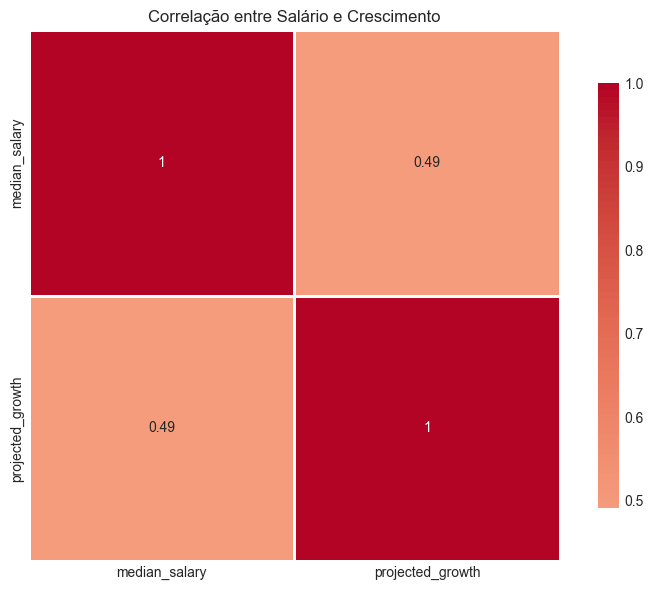

In [17]:
# Correlação numérica
correlation = df_complete[['median_salary', 'projected_growth']].corr()
print("=== Matriz de Correlação ===")
print(correlation)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlação entre Salário e Crescimento')
plt.tight_layout()
plt.show()

## 2.4 Análise de Habilidades

In [18]:
# Habilidades mais comuns
skill_counts = df_skills['skill_name'].value_counts()

print("=== Top 15 Habilidades Mais Comuns ===")
print(skill_counts.head(15))

=== Top 15 Habilidades Mais Comuns ===
skill_name
Problem Solving         16
Communication           15
Critical Thinking       11
Programming              6
Teamwork                 6
Adaptability             5
Time Management          5
Research                 5
Data Analysis            5
Healthcare Knowledge     3
Statistical Analysis     3
Leadership               3
Project Management       3
Business Analysis        3
Machine Learning         2
Name: count, dtype: int64


In [19]:
# Visualização: Habilidades mais demandadas
fig = px.bar(
    x=skill_counts.head(15).values,
    y=skill_counts.head(15).index,
    orientation='h',
    title='Top 15 Habilidades Mais Demandadas',
    labels={'x': 'Número de Ocupações', 'y': 'Habilidade'},
    color=skill_counts.head(15).values,
    color_continuous_scale='Blues'
)
fig.update_layout(height=500, showlegend=False)
fig.show()

---
# SEÇÃO 3: Modelagem (Machine Learning)

Nesta seção, iremos:
- Preparar dados para modelagem
- Implementar sistema de recomendação baseado em similaridade
- Treinar e validar o modelo
- Avaliar performance
- Salvar modelo para uso no webapp

## 3.1 Preparação dos Dados

In [20]:
# Carregar matriz de habilidades
X = skills_matrix_binary.copy()

print(f" Matriz de features carregada: {X.shape}")
print(f"   {X.shape[0]} ocupações, {X.shape[1]} habilidades")

# Criar labels
y = df_complete.set_index('occupation_code')['is_future_job'].reindex(X.index)

print(f"\nDistribuição das classes:")
print(y.value_counts())

 Matriz de features carregada: (20, 38)
   20 ocupações, 38 habilidades

Distribuição das classes:
is_future_job
True     12
False     8
Name: count, dtype: int64


In [21]:
# Normalizar dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

print(" Dados normalizados")

 Dados normalizados


## 3.2 Sistema de Recomendação Baseado em Similaridade

In [22]:
# Implementar modelo KNN
n_neighbors = 10
knn_model = NearestNeighbors(
    n_neighbors=n_neighbors,
    metric='cosine',
    algorithm='brute'
)

knn_model.fit(X)

print(f" Modelo KNN treinado com {n_neighbors} vizinhos")
print(f"   Métrica: Similaridade do Cosseno")

 Modelo KNN treinado com 10 vizinhos
   Métrica: Similaridade do Cosseno


## 3.3 Função de Recomendação

In [23]:
def recommend_occupations(user_skills, n_recommendations=10):
    # Criar vetor de habilidades do usuário
    user_vector = np.zeros((1, len(X.columns)))
    
    for skill in user_skills:
        if skill in X.columns:
            skill_idx = X.columns.get_loc(skill)
            user_vector[0, skill_idx] = 1
    
    # Encontrar ocupações similares
    distances, indices = knn_model.kneighbors(user_vector, n_neighbors=n_recommendations)
    
    # Converter distâncias para similaridade
    similarities = (1 - distances[0]) * 100
    
    # Obter códigos das ocupações recomendadas
    recommended_codes = X.index[indices[0]].tolist()
    
    # Criar DataFrame de resultados
    results = []
    for code, similarity in zip(recommended_codes, similarities):
        occ_data = df_complete[df_complete['occupation_code'] == code].iloc[0]
        results.append({
            'occupation_code': code,
            'occupation_title': occ_data['occupation_title'],
            'similarity_score': similarity,
            'median_salary': occ_data['median_salary'],
            'projected_growth': occ_data['projected_growth'],
            'is_future_job': occ_data['is_future_job']
        })
    
    return pd.DataFrame(results)

print(" Função de recomendação criada")

 Função de recomendação criada


## 3.4 Teste do Sistema de Recomendação

In [24]:
# Exemplo 1: Programação
print("=" * 80)
print("EXEMPLO 1: Habilidades de Programação e Dados")
print("=" * 80)

user_skills_1 = ['Programming', 'Data Analysis', 'Problem Solving', 'Critical Thinking']
print(f"\nHabilidades: {user_skills_1}")

recs_1 = recommend_occupations(user_skills_1, n_recommendations=5)
print("\nTop 5 Recomendações:")
print(recs_1[['occupation_title', 'similarity_score', 'projected_growth', 'median_salary']])

EXEMPLO 1: Habilidades de Programação e Dados

Habilidades: ['Programming', 'Data Analysis', 'Problem Solving', 'Critical Thinking']

Top 5 Recomendações:
                      occupation_title  similarity_score  projected_growth  median_salary
0           Machine Learning Engineers         81.649658              40.1         120000
1                      Data Scientists         75.592895              35.8         103500
2                   Robotics Engineers         61.237244               9.7         105000
3  Software Quality Assurance Analysts         61.237244              22.4          99620
4               Cybersecurity Analysts         61.237244              32.4         112000


In [25]:
# Exemplo 2: Gestão
print("=" * 80)
print("EXEMPLO 2: Habilidades de Gestão e Liderança")
print("=" * 80)

user_skills_2 = ['Leadership', 'Project Management', 'Communication', 'Business Analysis']
print(f"\nHabilidades: {user_skills_2}")

recs_2 = recommend_occupations(user_skills_2, n_recommendations=5)
print("\nTop 5 Recomendações:")
print(recs_2[['occupation_title', 'similarity_score', 'projected_growth', 'median_salary']])

EXEMPLO 2: Habilidades de Gestão e Liderança

Habilidades: ['Leadership', 'Project Management', 'Communication', 'Business Analysis']

Top 5 Recomendações:
                            occupation_title  similarity_score  projected_growth  median_salary
0  Computer and Information Systems Managers         81.649658              15.4         159010
1                 Sustainability Specialists         61.237244              19.7          81410
2                   Human Resources Managers         61.237244               8.6         126230
3    Career and Technical Education Teachers         40.824829               5.4          62000
4         Social Science Research Assistants         20.412415               6.8          51500


## 3.5 Avaliação do Modelo

In [26]:
def evaluate_recommendations(n_tests=100, skills_per_test=4, top_k=5):
    future_job_rate = []
    avg_growth_rate = []
    
    all_skills_list = X.columns.tolist()
    
    for _ in range(n_tests):
        random_skills = np.random.choice(all_skills_list, size=skills_per_test, replace=False)
        recs = recommend_occupations(random_skills.tolist(), n_recommendations=top_k)
        
        future_jobs_count = recs['is_future_job'].sum()
        future_job_rate.append(future_jobs_count / top_k)
        
        avg_growth = recs['projected_growth'].mean()
        avg_growth_rate.append(avg_growth)
    
    return {
        'future_job_rate': np.mean(future_job_rate) * 100,
        'avg_growth': np.mean(avg_growth_rate)
    }

print("Avaliando modelo...")
eval_results = evaluate_recommendations(n_tests=100)

print("\n=== RESULTADOS ===")
print(f"Taxa de Profissões do Futuro: {eval_results['future_job_rate']:.2f}%")
print(f"Crescimento Médio: {eval_results['avg_growth']:.2f}%")

baseline_future_rate = (df_complete['is_future_job'].sum() / len(df_complete)) * 100
baseline_growth = df_complete['projected_growth'].mean()

print("\n=== BASELINE ===")
print(f"Taxa de Profissões do Futuro: {baseline_future_rate:.2f}%")
print(f"Crescimento Médio: {baseline_growth:.2f}%")

Avaliando modelo...

=== RESULTADOS ===
Taxa de Profissões do Futuro: 51.60%
Crescimento Médio: 17.20%

=== BASELINE ===
Taxa de Profissões do Futuro: 60.00%
Crescimento Médio: 18.24%


## 3.6 Salvar Modelo

In [27]:
# Criar diretório de modelos
model_dir = Path('../app/model')
model_dir.mkdir(parents=True, exist_ok=True)

# Salvar modelo KNN
joblib.dump(knn_model, model_dir / 'model.pkl')
print(" Modelo salvo: app/model/model.pkl")

# Salvar scaler
joblib.dump(scaler, model_dir / 'preprocessor.pkl')
print(" Pré-processador salvo: app/model/preprocessor.pkl")

# Salvar informações adicionais
model_info = {
    'n_neighbors': n_neighbors,
    'metric': 'cosine',
    'n_occupations': len(X),
    'n_skills': len(X.columns),
    'skills_list': X.columns.tolist(),
    'future_job_rate': eval_results['future_job_rate'],
    'avg_growth': eval_results['avg_growth']
}

with open(model_dir / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(" Informações salvas: app/model/model_info.json")

print("\n" + "=" * 80)
print("MODELO PRONTO PARA USO NO WEBAPP!")
print("=" * 80)

 Modelo salvo: app/model/model.pkl
 Pré-processador salvo: app/model/preprocessor.pkl
 Informações salvas: app/model/model_info.json

MODELO PRONTO PARA USO NO WEBAPP!
